In [50]:
# Imports + Setup

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Make plots readable
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Paths
DATA_PATH = Path("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
OUT_DIR = Path("../outputs")
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete")


✅ Setup complete


In [51]:

# Load Data
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
df.info()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [52]:
# Check duplicates
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)


Duplicate rows: 0


In [53]:
# Missing values
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing values:")
display(missing)



Missing values:


Series([], dtype: int64)

In [54]:
# Quick look at unique values for categoricals (sample)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols:
    print(f"{c}: {df[c].nunique()} unique")

customerID: 7043 unique
gender: 2 unique
Partner: 2 unique
Dependents: 2 unique
PhoneService: 2 unique
MultipleLines: 3 unique
InternetService: 3 unique
OnlineSecurity: 3 unique
OnlineBackup: 3 unique
DeviceProtection: 3 unique
TechSupport: 3 unique
StreamingTV: 3 unique
StreamingMovies: 3 unique
Contract: 3 unique
PaperlessBilling: 2 unique
PaymentMethod: 4 unique
TotalCharges: 6531 unique
Churn: 2 unique


In [55]:

#     Cleaning (IMPORTANT for this dataset)
#    - Normalize Yes/No fields


df_clean = df.copy()

# Convert TotalCharges to numeric
if "TotalCharges" in df_clean.columns:
    df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

# Confirm missing after conversion (blanks become NaN)
print("Missing TotalCharges after conversion:", df_clean["TotalCharges"].isna().sum())

# Common strategy: TotalCharges is missing when tenure == 0, so fill with 0
# (or you can drop rows; filling is reasonable because charge accumulation at tenure 0 is often 0)
df_clean["TotalCharges"] = df_clean["TotalCharges"].fillna(0)

# Convert SeniorCitizen (0/1) to category for better grouping
if "SeniorCitizen" in df_clean.columns:
    df_clean["SeniorCitizen"] = df_clean["SeniorCitizen"].map({0: "No", 1: "Yes"}).astype("category")

# Standardize target
df_clean["Churn"] = df_clean["Churn"].str.strip().astype("category")

# Optional: drop customerID for analysis
if "customerID" in df_clean.columns:
    df_clean = df_clean.drop(columns=["customerID"])

print("✅ Cleaning done")
df_clean.info()


Missing TotalCharges after conversion: 11
✅ Cleaning done
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   str     
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   str     
 3   Dependents        7043 non-null   str     
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   str     
 6   MultipleLines     7043 non-null   str     
 7   InternetService   7043 non-null   str     
 8   OnlineSecurity    7043 non-null   str     
 9   OnlineBackup      7043 non-null   str     
 10  DeviceProtection  7043 non-null   str     
 11  TechSupport       7043 non-null   str     
 12  StreamingTV       7043 non-null   str     
 13  StreamingMovies   7043 non-null   str     
 14  Contract          7043 non-null   str     
 15  PaperlessBilling  7043 no

,count,rate
Churn,,
No,5174,0.73463
Yes,1869,0.26537


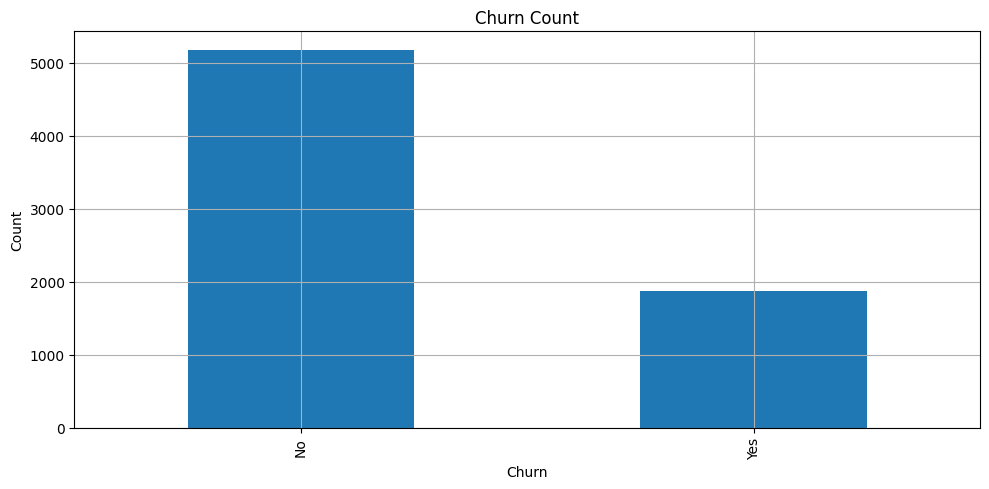

Churn rate (Yes): 0.265


In [56]:
# Target Understanding (Churn rate)

churn_counts = df_clean["Churn"].value_counts(dropna=False)
churn_rate = (churn_counts / churn_counts.sum()).rename("rate")

display(pd.concat([churn_counts.rename("count"), churn_rate], axis=1))

# Simple bar plot
ax = churn_counts.plot(kind="bar")
ax.set_title("Churn Count")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "churn_count.png", dpi=200)
plt.show()

print(f"Churn rate (Yes): {churn_rate.get('Yes', np.nan):.3f}")


Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


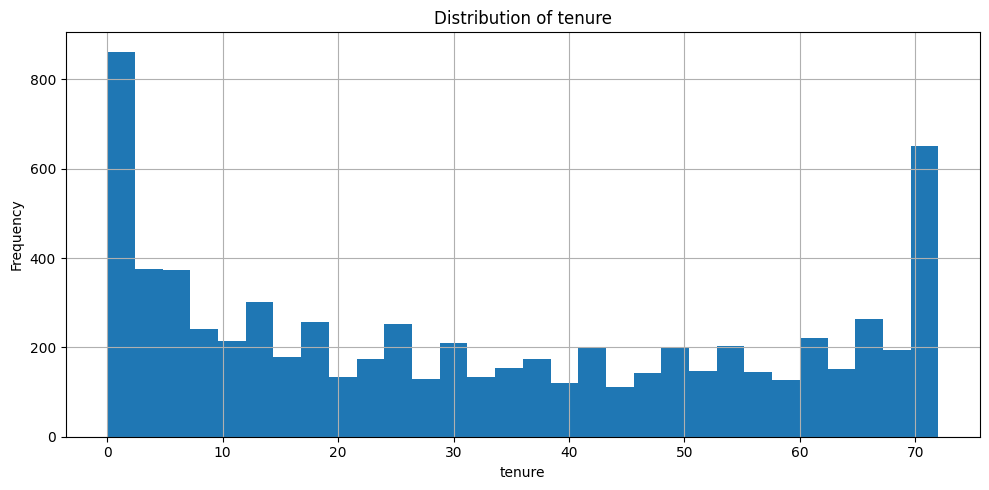

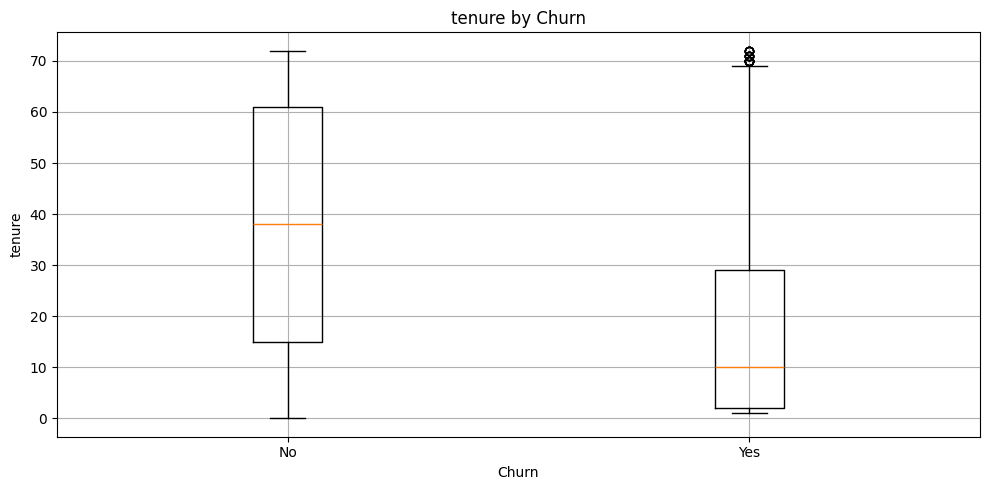

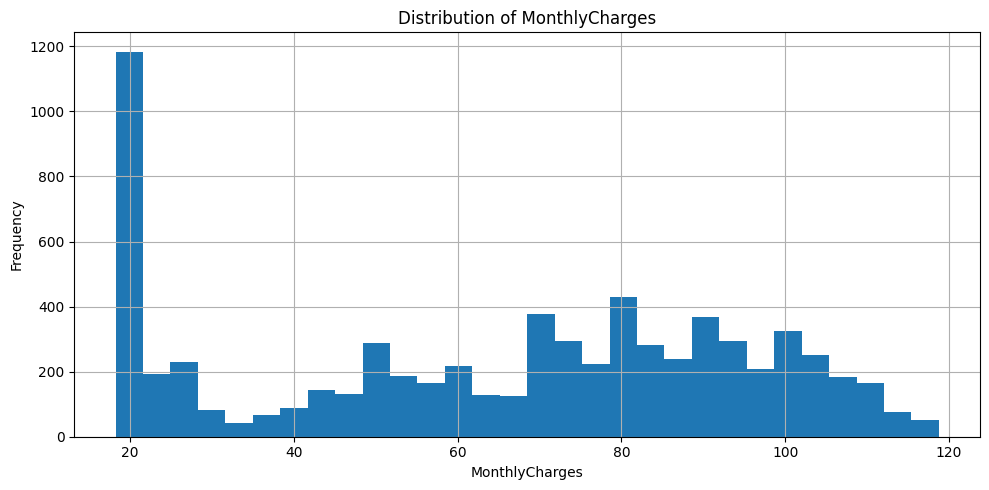

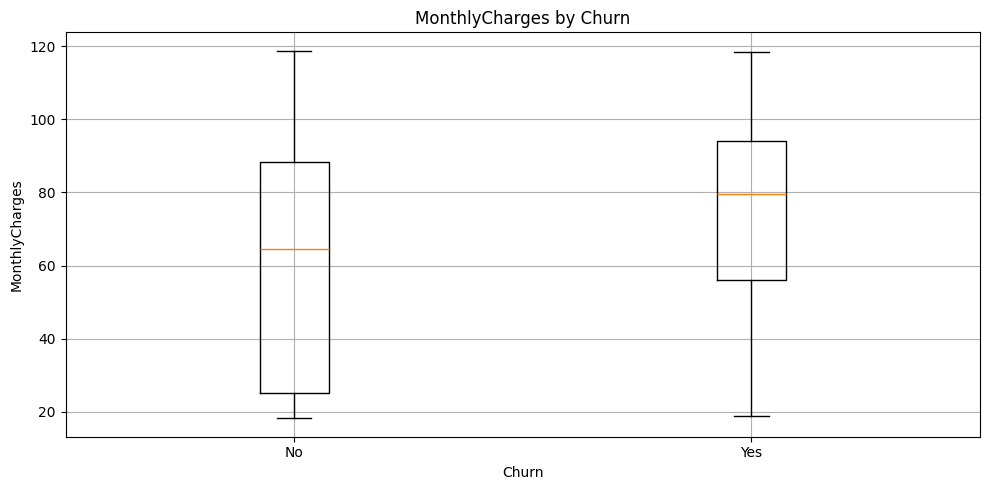

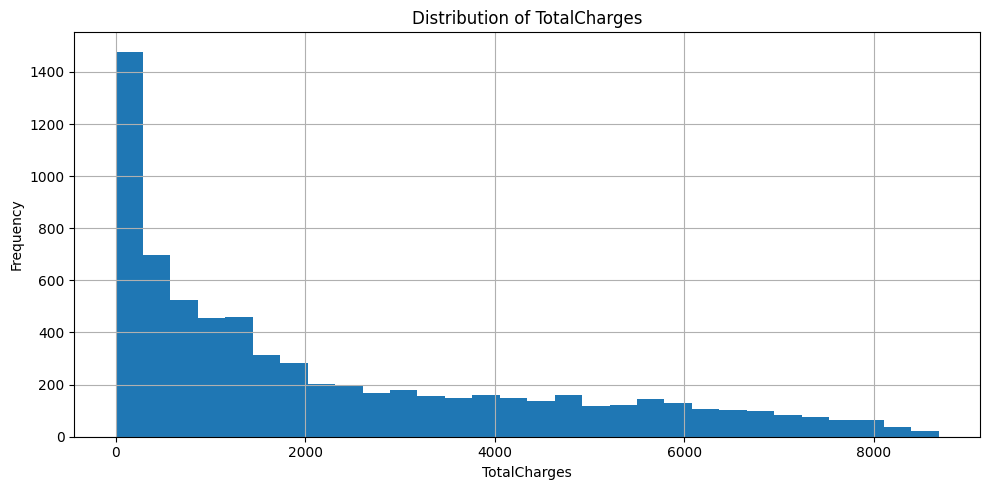

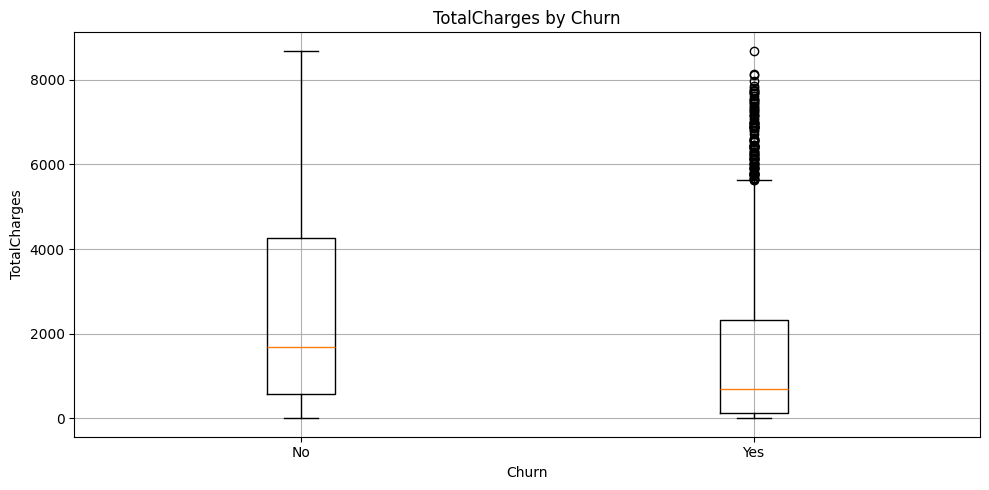

In [57]:
#  Univariate EDA (numeric)


num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

def plot_hist(series, title, fname):
    s = series.dropna()
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

def plot_box_by_churn(col, fname):
    # Two groups: churn yes/no
    yes = df_clean.loc[df_clean["Churn"] == "Yes", col].dropna()
    no  = df_clean.loc[df_clean["Churn"] == "No", col].dropna()

    plt.figure()
    plt.boxplot([no, yes], labels=["No", "Yes"])
    plt.title(f"{col} by Churn")
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

# Common important numerics
for c in [x for x in ["tenure", "MonthlyCharges", "TotalCharges"] if x in df_clean.columns]:
    plot_hist(df_clean[c], f"Distribution of {c}", f"hist_{c}.png")
    plot_box_by_churn(c, f"box_{c}_by_churn.png")


,Contract,rate,count
1,Month-to-month,0.427097,3875
3,One year,0.112695,1473
5,Two year,0.028319,1695


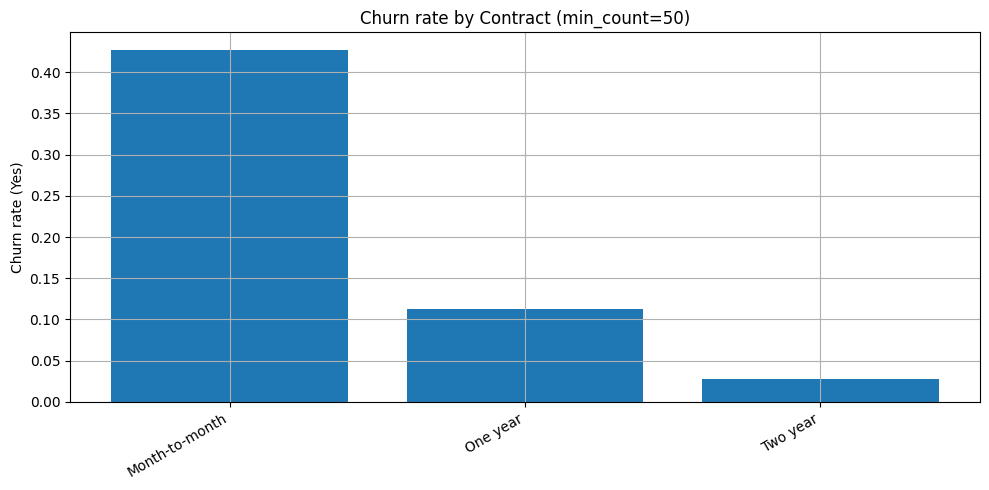

,PaymentMethod,rate,count
5,Electronic check,0.452854,2365
7,Mailed check,0.191067,1612
1,Bank transfer (automatic),0.167098,1544
3,Credit card (automatic),0.152431,1522


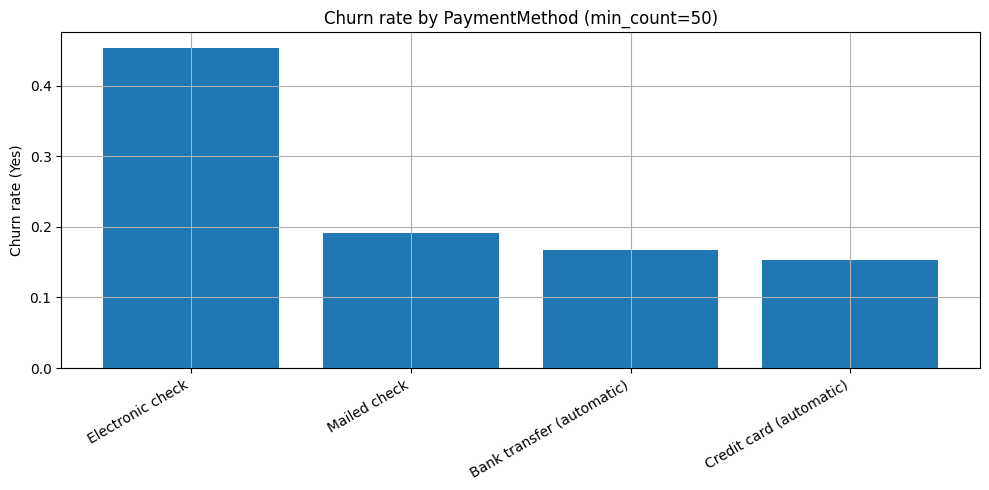

,InternetService,rate,count
3,Fiber optic,0.418928,3096
1,DSL,0.189591,2421
5,No,0.074050,1526


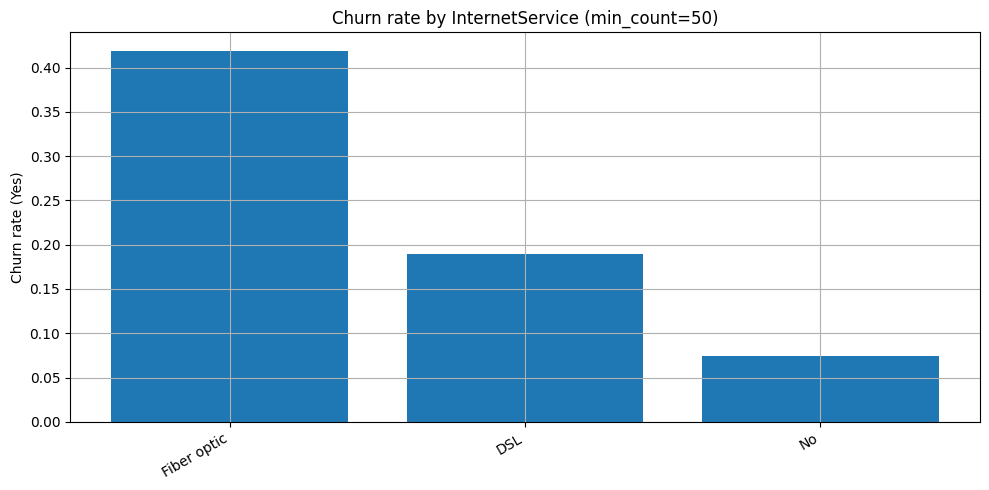

,TechSupport,rate,count
1,No,0.416355,3473
5,Yes,0.151663,2044
3,No internet service,0.074050,1526


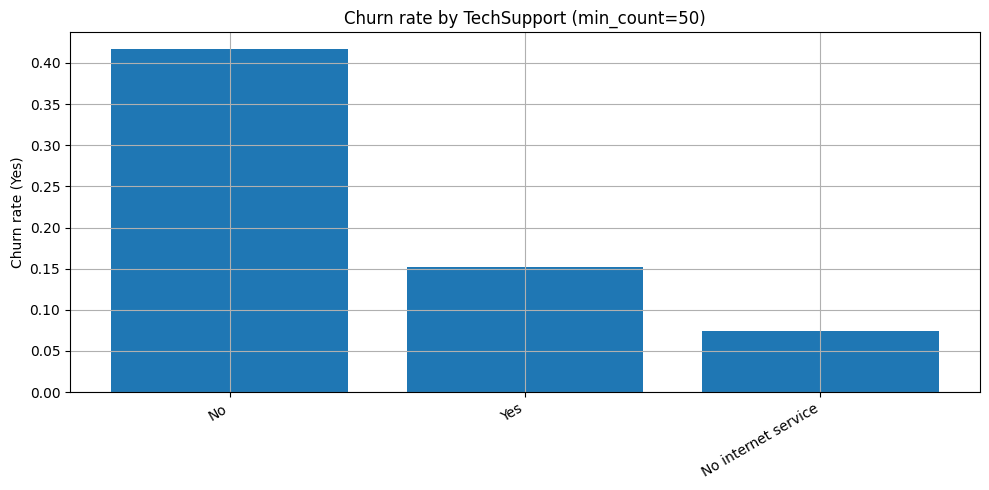

,OnlineSecurity,rate,count
1,No,0.417667,3498
5,Yes,0.146112,2019
3,No internet service,0.074050,1526


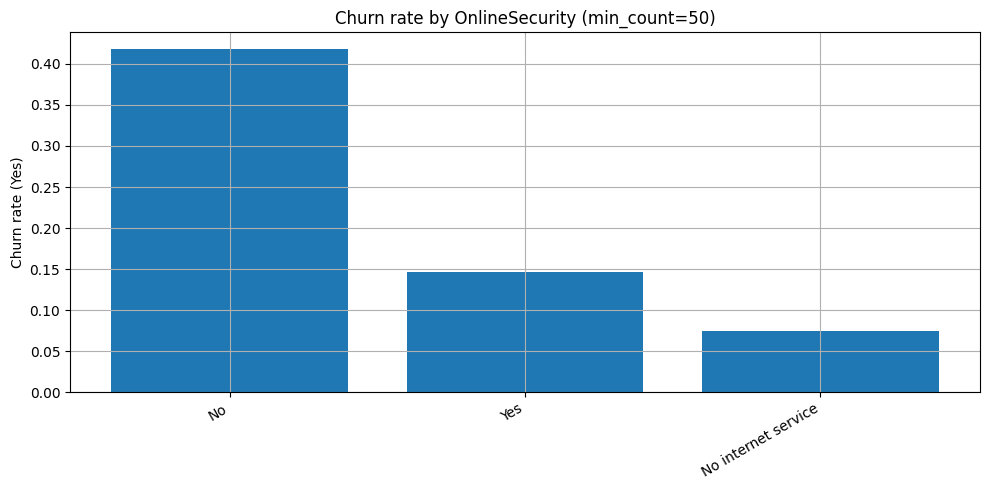

In [58]:

# 7) Bivariate EDA: Churn rate by category

def churn_rate_by_category(col, min_count=50):
    tmp = (
        df_clean.groupby(col)["Churn"]
        .value_counts(normalize=True)
        .rename("rate")
        .reset_index()
    )
    tmp_yes = tmp[tmp["Churn"] == "Yes"].drop(columns=["Churn"]).sort_values("rate", ascending=False)

    # Add counts for filtering tiny categories
    counts = df_clean[col].value_counts().rename("count")
    out = tmp_yes.merge(counts, left_on=col, right_index=True)
    out = out[out["count"] >= min_count].sort_values("rate", ascending=False)
    return out

def plot_churn_rate_by_category(col, fname, min_count=50):
    rates = churn_rate_by_category(col, min_count=min_count)
    if rates.empty:
        print(f"Skipping {col}: no categories meet min_count={min_count}")
        return

    plt.figure(figsize=(10, 5))
    plt.bar(rates[col].astype(str), rates["rate"])
    plt.title(f"Churn rate by {col} (min_count={min_count})")
    plt.ylabel("Churn rate (Yes)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

# Strong business columns to highlight first
priority_cats = [c for c in ["Contract", "PaymentMethod", "InternetService", "TechSupport", "OnlineSecurity"] if c in df_clean.columns]
for c in priority_cats:
    display(churn_rate_by_category(c, min_count=50).head(20))
    plot_churn_rate_by_category(c, f"churn_rate_by_{c}.png", min_count=50)


In [59]:

#  Statistical Tests
#    - Numeric vs churn: t-test + Mann–Whitney + effect size


def numeric_tests(col):
    yes = df_clean.loc[df_clean["Churn"] == "Yes", col].dropna()
    no  = df_clean.loc[df_clean["Churn"] == "No", col].dropna()

    # t-test (Welch)
    t_stat, t_p = stats.ttest_ind(yes, no, equal_var=False)

    # Mann–Whitney (non-parametric)
    u_stat, u_p = stats.mannwhitneyu(yes, no, alternative="two-sided")

    # Effect size: Cohen's d (approx using pooled std)
    # (Welch is used for p-value; d gives intuition on magnitude)
    mean_yes, mean_no = yes.mean(), no.mean()
    sd_yes, sd_no = yes.std(ddof=1), no.std(ddof=1)
    n_yes, n_no = len(yes), len(no)
    pooled_sd = np.sqrt(((n_yes - 1)*sd_yes**2 + (n_no - 1)*sd_no**2) / (n_yes + n_no - 2)) if (n_yes+n_no-2)>0 else np.nan
    cohens_d = (mean_yes - mean_no) / pooled_sd if pooled_sd and pooled_sd > 0 else np.nan

    return pd.Series({
        "mean_churn_yes": mean_yes,
        "mean_churn_no": mean_no,
        "t_pvalue": t_p,
        "mw_pvalue": u_p,
        "cohens_d": cohens_d,
        "n_yes": n_yes,
        "n_no": n_no
    })

num_test_cols = [c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in df_clean.columns]
num_results = pd.DataFrame({c: numeric_tests(c) for c in num_test_cols}).T
display(num_results.sort_values("t_pvalue"))
num_results.to_csv(TAB_DIR / "numeric_tests.csv", index=True)


,mean_churn_yes,mean_churn_no,t_pvalue,mw_pvalue,cohens_d,n_yes,n_no
tenure,17.979133,37.569965,1.195495e-232,2.419636e-208,-0.852250,1869.0,5174.0
TotalCharges,1531.796094,2549.911442,5.902581e-75,5.685034e-83,-0.458213,1869.0,5174.0
MonthlyCharges,74.441332,61.265124,8.592449e-73,3.311628e-54,0.446283,1869.0,5174.0


In [60]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000
